<font color=green> **Входные данные от банка — статистика о платёжеспособности клиентов.**  
Основная задача подготовить данные.  
Дополнительная разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

## Первичная информация о данных

* **children** — количество детей в семье 
* **days_employed** — общий трудовой стаж в днях  
* **dob_years** — возраст клиента в годах  
* **education** — уровень образования клиента  
* **education_id** — идентификатор уровня образования  
* **family_status** — семейное положение  
* **family_status_id** — идентификатор семейного положения  
* **gender** — пол клиента  
* **income_type** — тип занятости  
* **debt** — имел ли задолженность по возврату кредитов  
* **total_income** — ежемесячный доход  
* **purpose** — цель получения кредита

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymystem3 import Mystem

In [11]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

_Взглянув на таблицу сразу отметим два столбца с одинаковым количеством пропусков, столбец со стажем(в днях) некоторые данные выгружены с "-", а у клиента с индексом 4 стаж 932 года. Так же в столбце с образованием видна проблема с регистром, цель приобретения кредита скорее всего вписывается вручную, нужно разделить их на категории._  
_В любом случае нужно более подробно исследовать каждую переменную, даже если на первый взгляд ничего необычного не видно._  
_Проверим таблицу на дубликаты._  
_Стаж и ежемесячный доход сделаем целочислинными._

## **Предобработка**

### Данные о количестве детей

In [5]:
print('children:', *df['children'].unique())

children: 1 0 3 2 -1 4 20 5


In [6]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

_Аномальными являются "-1" и "20"_

_Есть предположение, что вместо "20" хотели ввести "2", вместо "-1" "1"_  
_Взгляним с каким признаком в таблице лучше коррелирует количество детей_

In [7]:
df[(df['children'] != -1) & (df['children'] != 20)].corr().round(2)['children'] # корреляция столбца "children" с остальными

children            1.00
days_employed      -0.24
dob_years          -0.31
education_id       -0.03
family_status_id   -0.16
debt                0.02
total_income        0.03
Name: children, dtype: float64

_Смотреть будем разброс количества детей по возрасту и сравнивать их между собой_

<AxesSubplot:xlabel='children', ylabel='dob_years'>

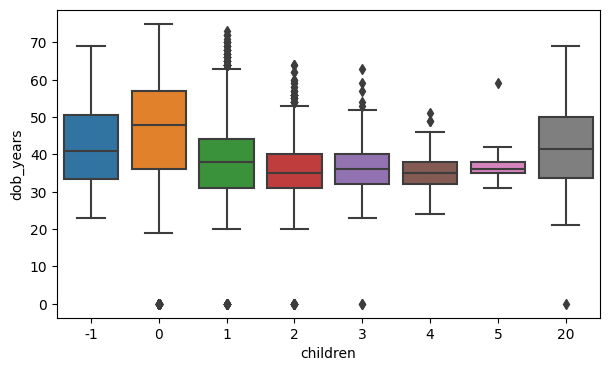

In [8]:
fig = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df, x='children', y='dob_years')

_Категории "20" и "-1" не похожи ни на одну отдельную группу, зато похожи между собой. Предположим, что обе ошибки распределены случайно по выборке_  
_Проверим это предположение_

<AxesSubplot:xlabel='children', ylabel='dob_years'>

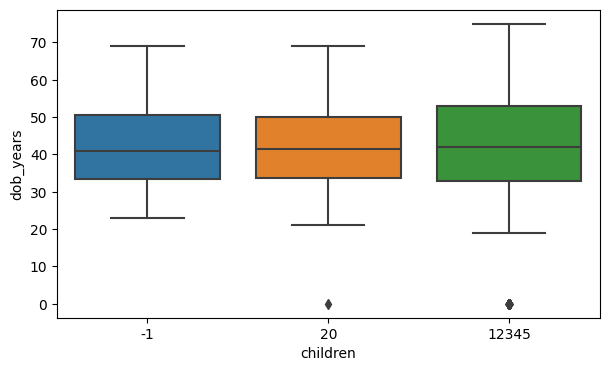

In [9]:
df_children_norm = df.copy()
df_children_norm['children'] = df_children_norm['children'].map(lambda x: 12345 if x in (0, 1, 2, 3, 4, 5) else x) # в столбце "children" объеденим 
                                                                                                                   # категории(0,1,2,3,4,5) в одну

fig = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df_children_norm, x='children', y='dob_years')

_Предположение не подтвердилось т.к. боксплоты "20" и "-1" больше всего похожи на боксплот всей остальной выборки, значит ошибка скорее всего распределена равномерно по разному количеству детей_  
_Решено удалить строки с данной ошибкой т.к. они составляют менее 0,6% от всех данных_

In [10]:
df = df.query('children != 20 and children != -1')

### Исправление аномальных значений в стаже

<AxesSubplot:xlabel='days_employed', ylabel='Count'>

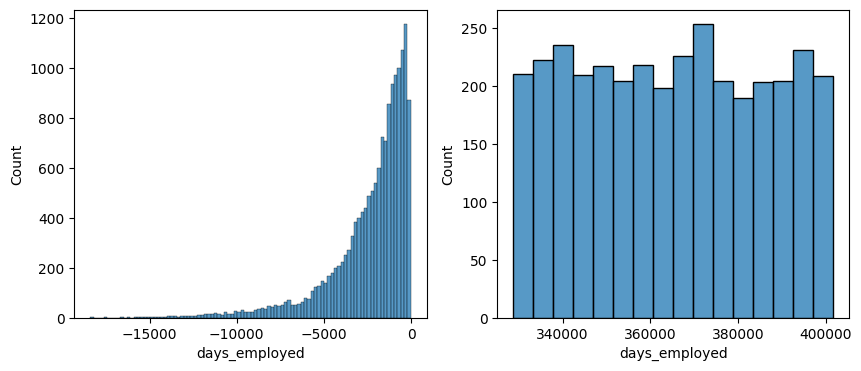

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df[df['days_employed'] < 0], x='days_employed', ax=ax[0])
sns.histplot(df[df['days_employed'] > 0], x='days_employed', ax=ax[1])

_Большинство данных о трудовом стаже выгружены со знаком "-", а еще часть не в днях, а в возможно в часах_

In [12]:
print(round(df[df['days_employed'] > 0]['days_employed'].min() / 24), round(df[df['days_employed'] > 0]['days_employed'].max() / 24), sep='   ') 

13697   16740


_Минимальное и максимальное значения трудового стажа, который предположительно был выгружен в часах, а не в днях_  
_Взглянем на то зависит ли наш аномальный трудовой стаж от типа занятости_

In [13]:
df[df['days_employed'] > 0]['income_type'].value_counts()

пенсионер      3429
безработный       2
Name: income_type, dtype: int64

_Почти все с большим трудовым стажем пенсионеры, принимаем предположение о выгрузке части данных в часах_

In [14]:
df['days_employed'] = df['days_employed'].apply(lambda x: x / 24 if x > 0 else x * (-1)) # одной функцией перевели стаж в дни и
                                                                                         # сделали его положительным

### Исправление нулевых значений возраста

_Зададим диапазон в котором будем считать значение возраста неподходящим - то есть ошибкой или неправильно выгруженными данными_

In [15]:
print(f"Болше 95 лет {(df['dob_years'] > 95).sum()} клиентов и меньше 18 лет {(df['dob_years'] < 18).sum()} клиентов")

Болше 95 лет 0 клиентов и меньше 18 лет 100 клиентов


In [16]:
df[['days_employed', 'dob_years']].corr()

,days_employed,dob_years
days_employed,1.000000,0.634582
dob_years,0.634582,1.000000


_Между трудовым стажем и возрастом есть прямая связь, воспользуемся этим фактом исправляя "0" возраст и заполняя пропуски в трудовам стаже_    
_Заполним "0" возраст на 20лет(предположительно в этом возрасте начинают работать) + days_employed(в годах)_

In [17]:
def format_years(row):             # функция изменения "0" в столбце возраста для у кого имеется стаж
    if not(np.isnan(row['days_employed'])) and row['dob_years'] == 0:
        row['dob_years'] = row['days_employed'] / 365 + 20
    return row
df = df.apply(format_years, axis=1)

In [18]:
df.loc[df['dob_years'] == 0, ['days_employed', 'dob_years', 'total_income']]

,days_employed,dob_years,total_income
1890,NaN,0.0,NaN
2284,NaN,0.0,NaN
4064,NaN,0.0,NaN
5014,NaN,0.0,NaN
6411,NaN,0.0,NaN
6670,NaN,0.0,NaN
8574,NaN,0.0,NaN
12403,NaN,0.0,NaN
13741,NaN,0.0,NaN
19829,NaN,0.0,NaN


_В данных 10 клиентов не определен ни стаж? ни возраст, ни ежемесячный доход, их количество невелико, поэтому решил исключить их из данных_ 

In [19]:
df = df.query('dob_years > 0')

### Пропуски в стаже

_Заполним пропущенные значения в "days_employed"(стаже), отталкиваясь от возраста клиента, с учетом что , большинство людей начинают работать в 20 лет_

In [20]:
df['days_employed'] = df['days_employed'].fillna((df['dob_years'] - 20) * 365)

In [21]:
(df['days_employed'] == 0).sum()

5

_Есть 1 отрицательное число, значит в строке со стажем "NaN" у одного клиента возраст меньше 20, сделаем его стаж 0_

In [22]:
df.loc[df['days_employed'] < 0, 'days_employed'] = 0

### Пропуски в доходе

In [23]:
df['total_income'].isna().sum()

2152

_Заполним пропуски медианным значением, сгруппированным по типу занятости и образованию_

In [24]:
df['total_income'] = df.groupby(['income_type', 'education_id'])['total_income'].apply(lambda x: x.fillna(x.median()))

### Исправление регистра в образовании

In [25]:
print('education:', *df['education'].unique(), sep=', ')

education:, высшее, среднее, Среднее, СРЕДНЕЕ, ВЫСШЕЕ, неоконченное высшее, начальное, Высшее, НЕОКОНЧЕННОЕ ВЫСШЕЕ, Неоконченное высшее, НАЧАЛЬНОЕ, Начальное, Ученая степень, УЧЕНАЯ СТЕПЕНЬ, ученая степень


In [26]:
print('education_id:', *df['education_id'].unique(), sep=', ')

education_id:, 0, 1, 2, 3, 4


_Приведем к нижнему регистру **education**_

In [27]:
df['education'] = df['education'].str.lower()

_Проверим на соответствие столбцы_ **education** _и_ **education_id**

In [28]:
df[['education', 'education_id']].drop_duplicates()

,education,education_id
0,высшее,0
1,среднее,1
13,неоконченное высшее,2
31,начальное,3
2963,ученая степень,4


### Семейное положение

In [29]:
print('family_status:', *df['family_status'].unique(), sep=', ')

family_status:, женат / замужем, гражданский брак, вдовец / вдова, в разводе, Не женат / не замужем


In [30]:
print('family_status_id:', *df['family_status_id'].unique(), sep=', ')

family_status_id:, 0, 1, 2, 3, 4


_Проверим на соответствие столбцы_ **family_status** _столбцам_ **family_status_id**

In [31]:
df[['family_status', 'family_status_id']].drop_duplicates()

,family_status,family_status_id
0,женат / замужем,0
4,гражданский брак,1
18,вдовец / вдова,2
19,в разводе,3
24,Не женат / не замужем,4


### Пол клиента

In [32]:
df['gender'].value_counts()

F      14146
M       7245
XNA        1
Name: gender, dtype: int64

_Удаляем XNA_

In [33]:
df = df[df['gender'] != 'XNA']

### Тип занятости

In [34]:
print('income_type:', *df['income_type'].unique(), sep=', ')

income_type:, сотрудник, пенсионер, компаньон, госслужащий, безработный, предприниматель, студент, в декрете


In [35]:
df['income_type'].value_counts()

сотрудник          11045
компаньон           5051
пенсионер           3836
госслужащий         1453
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

### Задолженность по кредитам

In [36]:
print('debt:', *df['debt'].unique(), sep=', ')

debt:, 0, 1


### Обработка дубликатов

In [37]:
df.duplicated().sum()

71

In [38]:
df = df.drop_duplicates().reset_index(drop=True)

### Категоризация целей кредита

In [39]:
print(*df['purpose'].unique(), sep=', ', end='\n\n')
print(f"число категорий {len(df['purpose'].unique())}")

покупка жилья, приобретение автомобиля, дополнительное образование, сыграть свадьбу, операции с жильем, образование, на проведение свадьбы, покупка жилья для семьи, покупка недвижимости, покупка коммерческой недвижимости, покупка жилой недвижимости, строительство собственной недвижимости, недвижимость, строительство недвижимости, на покупку подержанного автомобиля, на покупку своего автомобиля, операции с коммерческой недвижимостью, строительство жилой недвижимости, жилье, операции со своей недвижимостью, автомобили, заняться образованием, сделка с подержанным автомобилем, получение образования, автомобиль, свадьба, получение дополнительного образования, покупка своего жилья, операции с недвижимостью, получение высшего образования, свой автомобиль, сделка с автомобилем, профильное образование, высшее образование, покупка жилья для сдачи, на покупку автомобиля, ремонт жилью, заняться высшим образованием

число категорий 38


_Выделяются только 4 категории, недвижимость, автомобиль, образование, свадьба, но записаны как 38. С помощью функции выделим из каждой записи леммы каждого слова и приведем к одному из 4 вариантовю._

In [40]:
m = Mystem()

In [41]:
def purpose_standart(purpose):    #функция преведения к стандартной записи цели кредита их 4
    lem=m.lemmatize(purpose)                                                               # 'операции с автомобилем'
    if ('недвижимость' in lem) or ('жилье' in lem):                                        
        return 'операции с недвижимостью'                                                  #'операции с недвижимостью'
    elif 'автомобиль' in lem:
        return 'операции с автомобилем'                                                    #'операции с автомобилем'
    elif 'образование' in lem:
        return 'получение образования'                                                     #'получение образования'
    elif 'свадьба' in lem:                
        return 'проведение свадьбы'                                                        #'проведение свадьбы'
    else:
        return s

_Записи во всей таблице будут непозволительно долго лемматизироваться, поэтому создадим словарь с 38 ключами(сырые категории) и 4 значениями(приведенные категории). Изменим столбец обращаясь к словарю._

In [42]:
dict_purpose = {purpose: purpose_standart(purpose) for purpose in df['purpose'].unique()} #создадим словарь с шаблонными целямя для кредита 
                                                                                          #ключ-описание цели кредита в исходной таблице
                                                                                          #значение-преобразованная цель кредита

In [43]:
df['purpose'] = df['purpose'].apply(lambda x: dict_purpose[x])

In [44]:
df['purpose'].unique()

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы'], dtype=object)

### Изменение типов данных

In [45]:
df = df.astype({'days_employed': int, 'dob_years': int, 'total_income': int})

### Разбиение клиентов на категории по уровню дорхода(E, D, C, B, A)

In [46]:
df['income_group'] = pd.Series(pd.cut(df['total_income'], bins=[0, 60001, 120001, 200001, 600001, 2500001], labels=['E', 'D', 'C', 'B', 'A']))

### Определение налячия зависимости наличия детей и возвратом кредита в срок

_Сделаем сводную таблицу по количеству детей  
Посчитаем в ней количество клиентов имевших просроченную задолженость, общее количество, и процент задолжавших_

In [47]:
df.pivot_table(index='children', values='debt', aggfunc=['sum', 'count', 'mean']).reset_index() \
    .set_axis(['children', 'bad_debt', 'all_debt', 'value_%'], axis='columns').style.format({'value_%': '{:.1%}'})

,children,bad_debt,all_debt,value_%
0,0,1063,14082,7.5%
1,1,444,4807,9.2%
2,2,194,2052,9.5%
3,3,27,329,8.2%
4,4,4,41,9.8%
5,5,0,9,0.0%


_Для категории с 5 детьми наш низкий % скорее всего обуславливается недостаточным количеством наблюдений в выборке  
Для остальных наблюдается повышение общего тренда задержек с увеличением количества детей_ 

### Определение зависимости между семейным положением и возвратом кредита в срок

_Сводная таблица по семейному положению_

In [48]:
df.pivot_table(index='family_status', values='debt', aggfunc=['sum', 'count', 'mean']).reset_index() \
    .set_axis(['family_status', 'bad_debt', 'all_debt', 'value_%'], axis='columns').style.format({'value_%': '{:.1%}'})

,family_status,bad_debt,all_debt,value_%
0,Не женат / не замужем,273,2795,9.8%
1,в разводе,84,1188,7.1%
2,вдовец / вдова,63,950,6.6%
3,гражданский брак,385,4130,9.3%
4,женат / замужем,927,12257,7.6%


_Видно, что наиболее надежные заемщики те кто находятся, либо находились в законном браке  
Самы низкий % задержек у вдовцов/вдов, возможно потому что как правило вдовцы/вдовы пожилые люди_ 

### Определение зависимости между уровнем дохода и возвратом кредита в срок

_Сводная таблица по уровню дохода_

In [49]:
df.pivot_table(index='income_group', values='debt', aggfunc=['sum', 'count', 'mean']).reset_index() \
    .set_axis(['income_group', 'bad_debt', 'all_debt', 'value_%'], axis='columns').style.format({'value_%': '{:.1%}'})

,income_group,bad_debt,all_debt,value_%
0,E,49,801,6.1%
1,D,531,6333,8.4%
2,C,788,8965,8.8%
3,B,356,5112,7.0%
4,A,8,109,7.3%


_Линейной зависимости не наблюдается, скорее всего зависимость сложнее т.к. категория клиентов с самым низким доходом имеет меньше задержек чем остальные, возможно это связано с небольшой суммой кредитов_

### Определение зависимости между целями кредита и возвратом кредита в срок

In [50]:
df.pivot_table(index='purpose', values='debt', aggfunc=['sum', 'count', 'mean']).reset_index() \
    .set_axis(['income_group', 'bad_debt', 'all_debt', 'value_%'], axis='columns').style.format({'value_%': '{:.1%}'})

,income_group,bad_debt,all_debt,value_%
0,операции с автомобилем,400,4279,9.3%
1,операции с недвижимостью,780,10742,7.3%
2,получение образования,369,3988,9.3%
3,проведение свадьбы,183,2311,7.9%


_Кредиты на операции с недвижимостью менее проблемны чем на другие цели_

### Итог

В данной работе с выгруженными данными были проведены следующие операции: 
- изучение признаков  
- проведен анализ появления аномалий в данных и их исправление  
- исправление нулевых значений, где их не должно быть, заполнение пропусков
- избавление от дубликатов
- с помощью лемматизации унифицировали категории целей кредита
- категоризовали клиентов по уровню дохода  

Нашли разницу в долях проблемных кредитов разделенных по категориям:
- количество детей
- семейное положение
- уровень дохода
- цели кредита